In [16]:
import networkx as nx
import numpy as np
import pysmiles
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from enum import Enum

In [4]:
benzene = "C1=CC=CC=C1"
anisole = "COC1=CC=CC=C1"
bucky = 'C12=C3C4=C5C6=C1C7=C8C9=C1C%10=C%11C(=C29)C3=C2C3=C4C4=C5C5=C9C6=C7C6=C7C8=C1C1=C8C%10=C%10C%11=C2C2=C3C3=C4C4=C5C5=C%11C%12=C(C6=C95)C7=C1C1=C%12C5=C%11C4=C3C3=C5C(=C81)C%10=C23'


In [59]:
weight_map = {
    'SINGLE': 1,
    'AROMATIC': 1.5,
    'DOUBLE': 2,
    'TRIPLE': 3
}

In [60]:
def mol_to_graph(mol):
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), atomic_num=atom.GetAtomicNum(), is_aromatic=atom.GetIsAromatic(), symbol=atom.GetSymbol())
    for bond in mol.GetBonds():
        bond_weight = weight_map[str(bond.GetBondType())]
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType(), weight=bond_weight)
    return G

In [61]:
def draw_mol(G):
    pos = nx.spring_layout(G)
    elements = nx.get_node_attributes(G, name="symbol")
    nx.draw(G, pos, with_labels=True, labels=elements)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

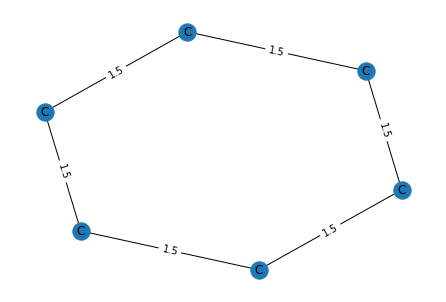

In [62]:
mol = Chem.MolFromSmiles(benzene)
G = mol_to_graph(mol)
draw_mol(G)

In [63]:
data = pd.read_csv("B3DB/B3DB/B3DB_classification.tsv", sep="\t")
data_ext = pd.read_csv("B3DB/B3DB/B3DB_classification_extended.tsv.gz", sep="\t", compression="gzip")

/var/folders/wz/sl0zwknj6q3bt1yxsdtmc0mr0000gn/T/ipykernel_29746/283256523.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ext = pd.read_csv("B3DB/B3DB/B3DB_classification_extended.tsv.gz", sep="\t", compression="gzip")


0 O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O
sulphasalazine


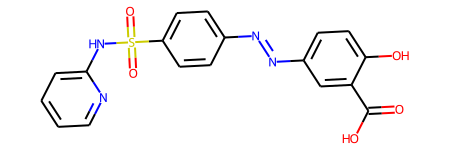

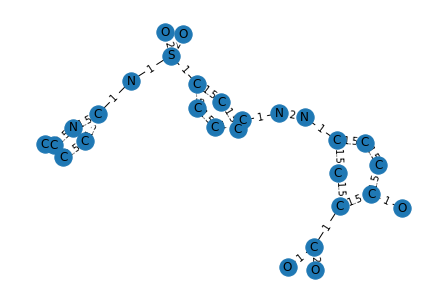

1 COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)O)=C(CSc3nnnn3C)COC21
moxalactam


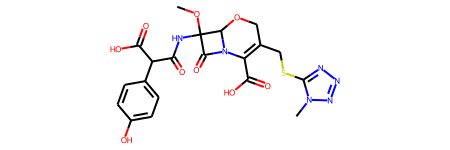

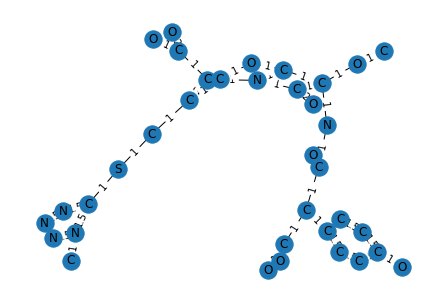

2 Oc1c(I)cc(Cl)c2cccnc12
clioquinol


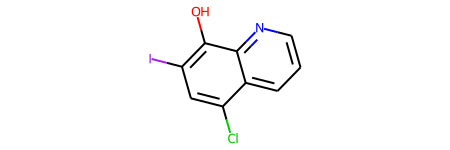

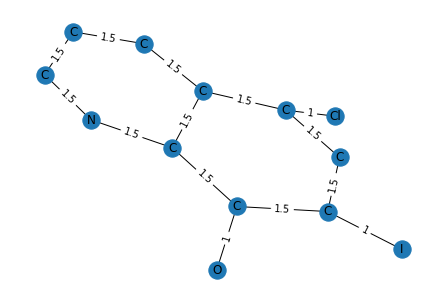

3 CCNC(=NCCSCc1ncccc1Br)NC#N
bbcpd11 (cimetidine analog) (y-g13)


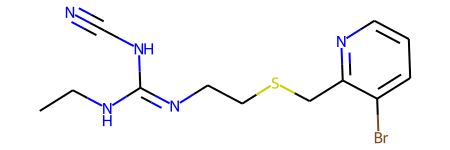

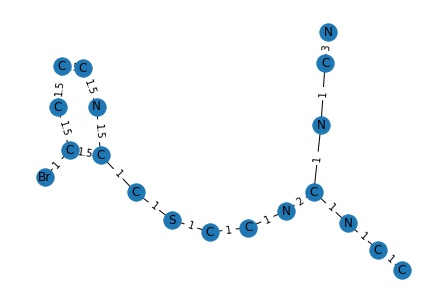

4 CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]6O)c4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5
schembl614298


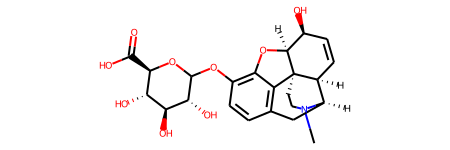

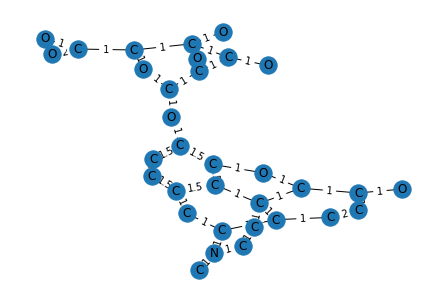

5 CS(=O)(=O)N(CCO)c1c(Cl)c(Cl)cc2[nH]c(=O)c(=O)[nH]c12
uk-240,455


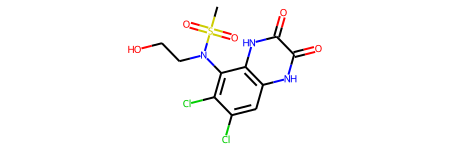

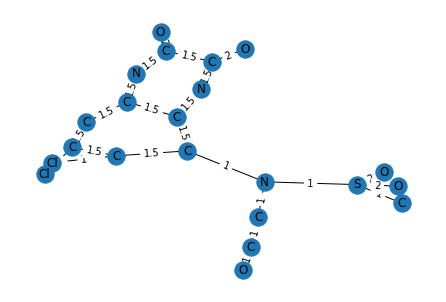

6 CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](OC2O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]2O)C=C[C@H]3[C@H]1C5
morphine-6-glucuronide


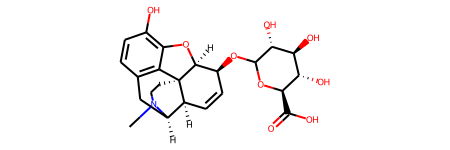

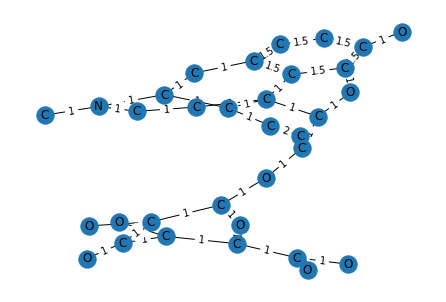

7 O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1
nitrofurantoin


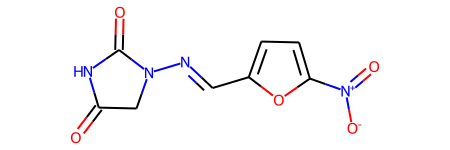

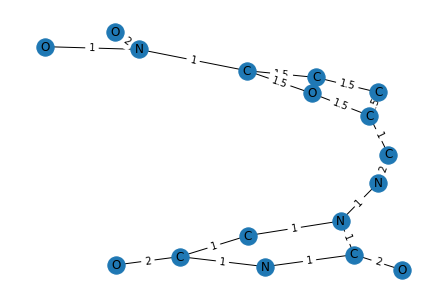

8 O=c1[nH]c2cc(Cl)ccc2c(O)c1-c1cccc(Oc2ccccc2)c1
l-701,324


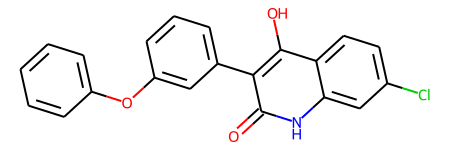

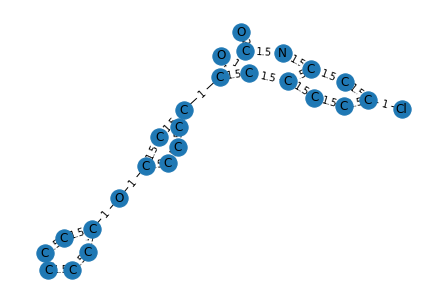

9 COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O
33419-42-0


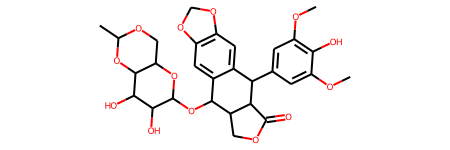

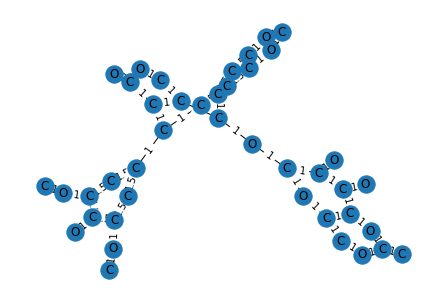

In [64]:
for i, row in data.head(10).iterrows():
    print(i, row['SMILES'])
    print(row['compound_name'])
    mol = Chem.MolFromSmiles(row['SMILES'])
    display(mol)
    G = mol_to_graph(mol)
    draw_mol(G)